# **Exercise 2: data visualization & clustering**

In [47]:
# %matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.ticker import NullFormatter
from matplotlib.patches import Rectangle

from ipywidgets import interact, BoundedIntText

plt.rcParams['font.size'] = 13

from sklearn import manifold 
from sklearn import metrics
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from time import time

from collections import OrderedDict

from scipy import linalg as la
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster, set_link_color_palette

import seaborn as sns

import pandas as pd

## Data and labels 
In this example we know the labels, hence we can test the performances of t-SNE and DBSCAN

In [20]:
# file names
fname,fnamey="x_12d.dat","y_12d.dat"

# data
data=np.loadtxt("DATA/"+fname, delimiter='\t')
x=data

# labels
y=np.loadtxt("DATA/"+fnamey,dtype=int)
lab, num = np.unique(y, return_counts=True)
print('Classes:', lab)
print('Samples in each class:', num)

# data dimension
N=len(data)
D=len(data[0])

print()
print('Data dimension:')
print("N =",N,"  L = D = ",D)

Classes: [0 1 2]
Samples in each class: [229 247 124]

Data dimension:
N = 600   L = D =  12


## Find the typical minimum distance between points
This yields a typical scale, to be used as a reference for "eps"

mean minimum distance between points: 162.35


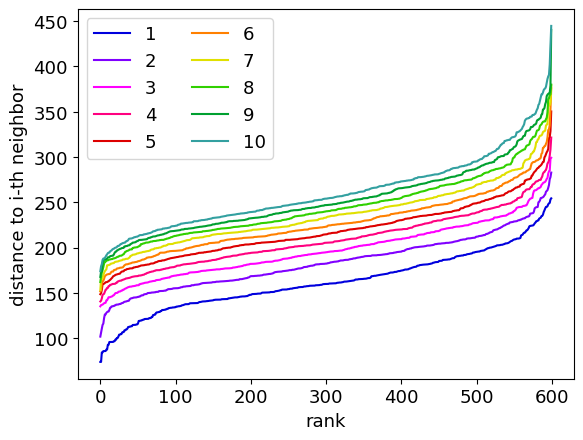

In [21]:
# number of nearest neighbors
nn = 10

# fitting the algorithm on our data
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(x) #, algorithm='ball_tree'

# retrieving distances matrix for every point from every i-th neighbor
d, ind = nbrs.kneighbors(x)
# transposing the distances matrix
# note: dd[0] has a trivial set of zeros
dd=d.T

# colors for the plot
listc= ["#0000DD","#8000FF","#FF00FF","#FF0080","#DD0000",
        "#FF8000","#E0E000","#30D000","#00A030","#33A0A0"]

# mean distance of the first neighbor
mean_min_dist = np.mean(dd[1])
print(f"mean minimum distance between points: {mean_min_dist:.2f}")

# visualization of the ranked distance
for i in range(1,nn+1):
    plt.plot(np.sort(dd[i]),c=listc[i-1],label=str(i))
    plt.xlabel("rank")
    plt.ylabel("distance to i-th neighbor")
plt.legend(ncol=2)
plt.show()

## t-SNE visualization, for true labels

Time for the fit with perplexity = 2: 1.53 s
Time for the fit with perplexity = 4: 1.52 s
Time for the fit with perplexity = 8: 1.36 s
Time for the fit with perplexity = 16: 2.11 s
Time for the fit with perplexity = 32: 2.81 s


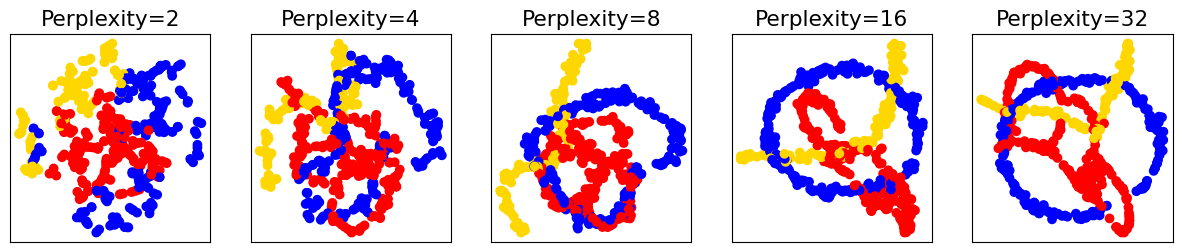

In [22]:
np.random.seed(0)

# dataset dimension
n_samples = N

# visualization on the plane
n_components = 3

# perplexity parameters
perplexities = [2, 4, 8, 16, 32]
Np = len(perplexities)

# colors
mycmap = ListedColormap(["blue","red","gold" ])

# visualization with different perplexities
(fig, subplots) = plt.subplots(1,Np , figsize=(3*Np, 2.7))

# list to store low dimensional data
X_all = [None]

# plots
for i, perplexity in enumerate(perplexities):
    ax = subplots[i]
    # calculating time for the fit
    t0 = time()
    # embedding
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',
                         random_state=0, # same random state for all perplexities
                         perplexity=perplexity)
    # retrieving transformed data in low-dimensional space
    Y = tsne.fit_transform(data)
    t1 = time()
    print(f'Time for the fit with perplexity = {perplexity}: {t1-t0:.2f} s' )

    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## Different random initial states (random_state=i)

Time for the fit with perplexity = 16: 2.31 s
Time for the fit with perplexity = 16: 2.55 s
Time for the fit with perplexity = 16: 2.44 s
Time for the fit with perplexity = 16: 2.52 s
Time for the fit with perplexity = 16: 2.47 s


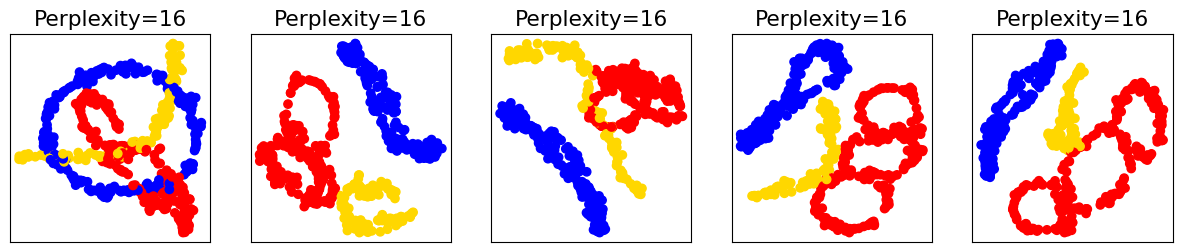

In [23]:
# visualization with different random initial states

(fig, subplots) = plt.subplots(1, Np, figsize=(3*Np, 2.7))

# list to store low dimensional data
X_all = [None]

# fixed perplexity (the besto one from plot above)
perplexity= 16

for i in range(5):
    np.random.seed(i) 
    ax = subplots[i]
    # calculating time for the fit
    t0 = time()
    # embedding
    tsne = manifold.TSNE(n_components=n_components, 
                         init='random',
                         random_state=i, # different random state
                         perplexity=perplexity)
    # retrieving transformed data in low-dimensional space
    Y = tsne.fit_transform(data)
    t1 = time()
    print(f'Time for the fit with perplexity = {perplexity}: {t1-t0:.2f} s' )
    ax.set_title("Perplexity=%d" % perplexity)
    ax.scatter(Y[:, 0], Y[:, 1], c=y,cmap=mycmap)
    ax.tick_params(left=False,bottom=False)
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    ax.axis('tight')
    X_all.append(Y)
    
plt.show()

## DBSCAN: find labels by applying clustering

In [24]:
# colors
cpalette = ["blue","red","gold","black","magenta","green","cyan","#1CE6FF", "#FF34FF", "#FF4A46","#008941", "#006FA6", "#A30059", "#0000A6", "#63FFAC","#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693","#1B4400", "#4FC601", "#3B5DFF", "#4A3B53","#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C","#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F"]

In [25]:
def clustering(y): # arg : labelled data 
    # Finds position of labels and returns a dictionary of cluster labels to data indices.
    # Function that return a dictionary with: (label of the cluster  -  indices of the data (y) in that specific cluster)
    yu = np.sort(np.unique(y))
    clustering = OrderedDict()   # initializing dictionary
    for ye in yu:
        clustering[ye] = np.where(y == ye)[0]    # fill the dictionary
    return clustering

def entropy(c, n_sample):   # c = dictionary (clusters) 
                            # n_sample = total number of sample
    # Measures the entropy of a cluster
    # if the density is well distributed among the clusters 
    # then the entropy of the clustering system is low 
    # if the density is bad distributed among the clusters 
    # then the entropy is high
    # useful to measure the quality of the clustering

    # clustering entropy initialization
    h = 0.  
    for kc in c.keys(): # loops on the clusters  kc
        # probability of a sample to be clustered in kc (or density of the cluster kc) 
        p=len(c[kc])/n_sample  
        # adding the entropy of kc on the global entropy  
        # note that log(p) is a negative number beacuse p<1   
        h+=p*np.log(p)   
    h*=-1.  # make the entropy positive
    return h

# Normalized mutual information function
# Note that this deals with the label permutation problem
# This function can describe the difference of information 
# between the real data labels (real clusters) and the predicted one --> commutative 
def NMI(y_true, y_pred):    # arg: (true label, predicted label)
    """ Computes normalized mutual information: where y_true and y_pred are both clustering assignments
    """
    w = clustering(y_true)  # dictionary of the true labels
    c = clustering(y_pred)  # dictionary of predicted labels
    n_sample = len(y_true)

    # cumulative information between w and c 
    Iwc = 0.    

    # compare the predicted clusters and the true ones
    # count the number of shared/intersected data (correctly clusterized)
    for kw in w.keys(): # looping true clusters
        for kc in c.keys(): # looping pred clusters
            # find if they share some data
            w_intersect_c=len(set(w[kw]).intersection(set(c[kc]))) 
            # if they share data increase mutual information 
            if w_intersect_c > 0:
                Iwc += w_intersect_c*np.log(n_sample*w_intersect_c/(len(w[kw])*len(c[kc]))) 
    # normalization
    Iwc/=n_sample   
    Hc = entropy(c,n_sample)
    Hw = entropy(w,n_sample)

    return 2*Iwc/(Hc+Hw)

def plotting_ax(X, y, ax):
    # point size
    ms = 6
    for i, yu in enumerate(np.unique(y)):
        pos = (y == yu)
        ax.scatter(X[pos,0], X[pos,1],c=cpalette[i%len(cpalette)],s=ms)

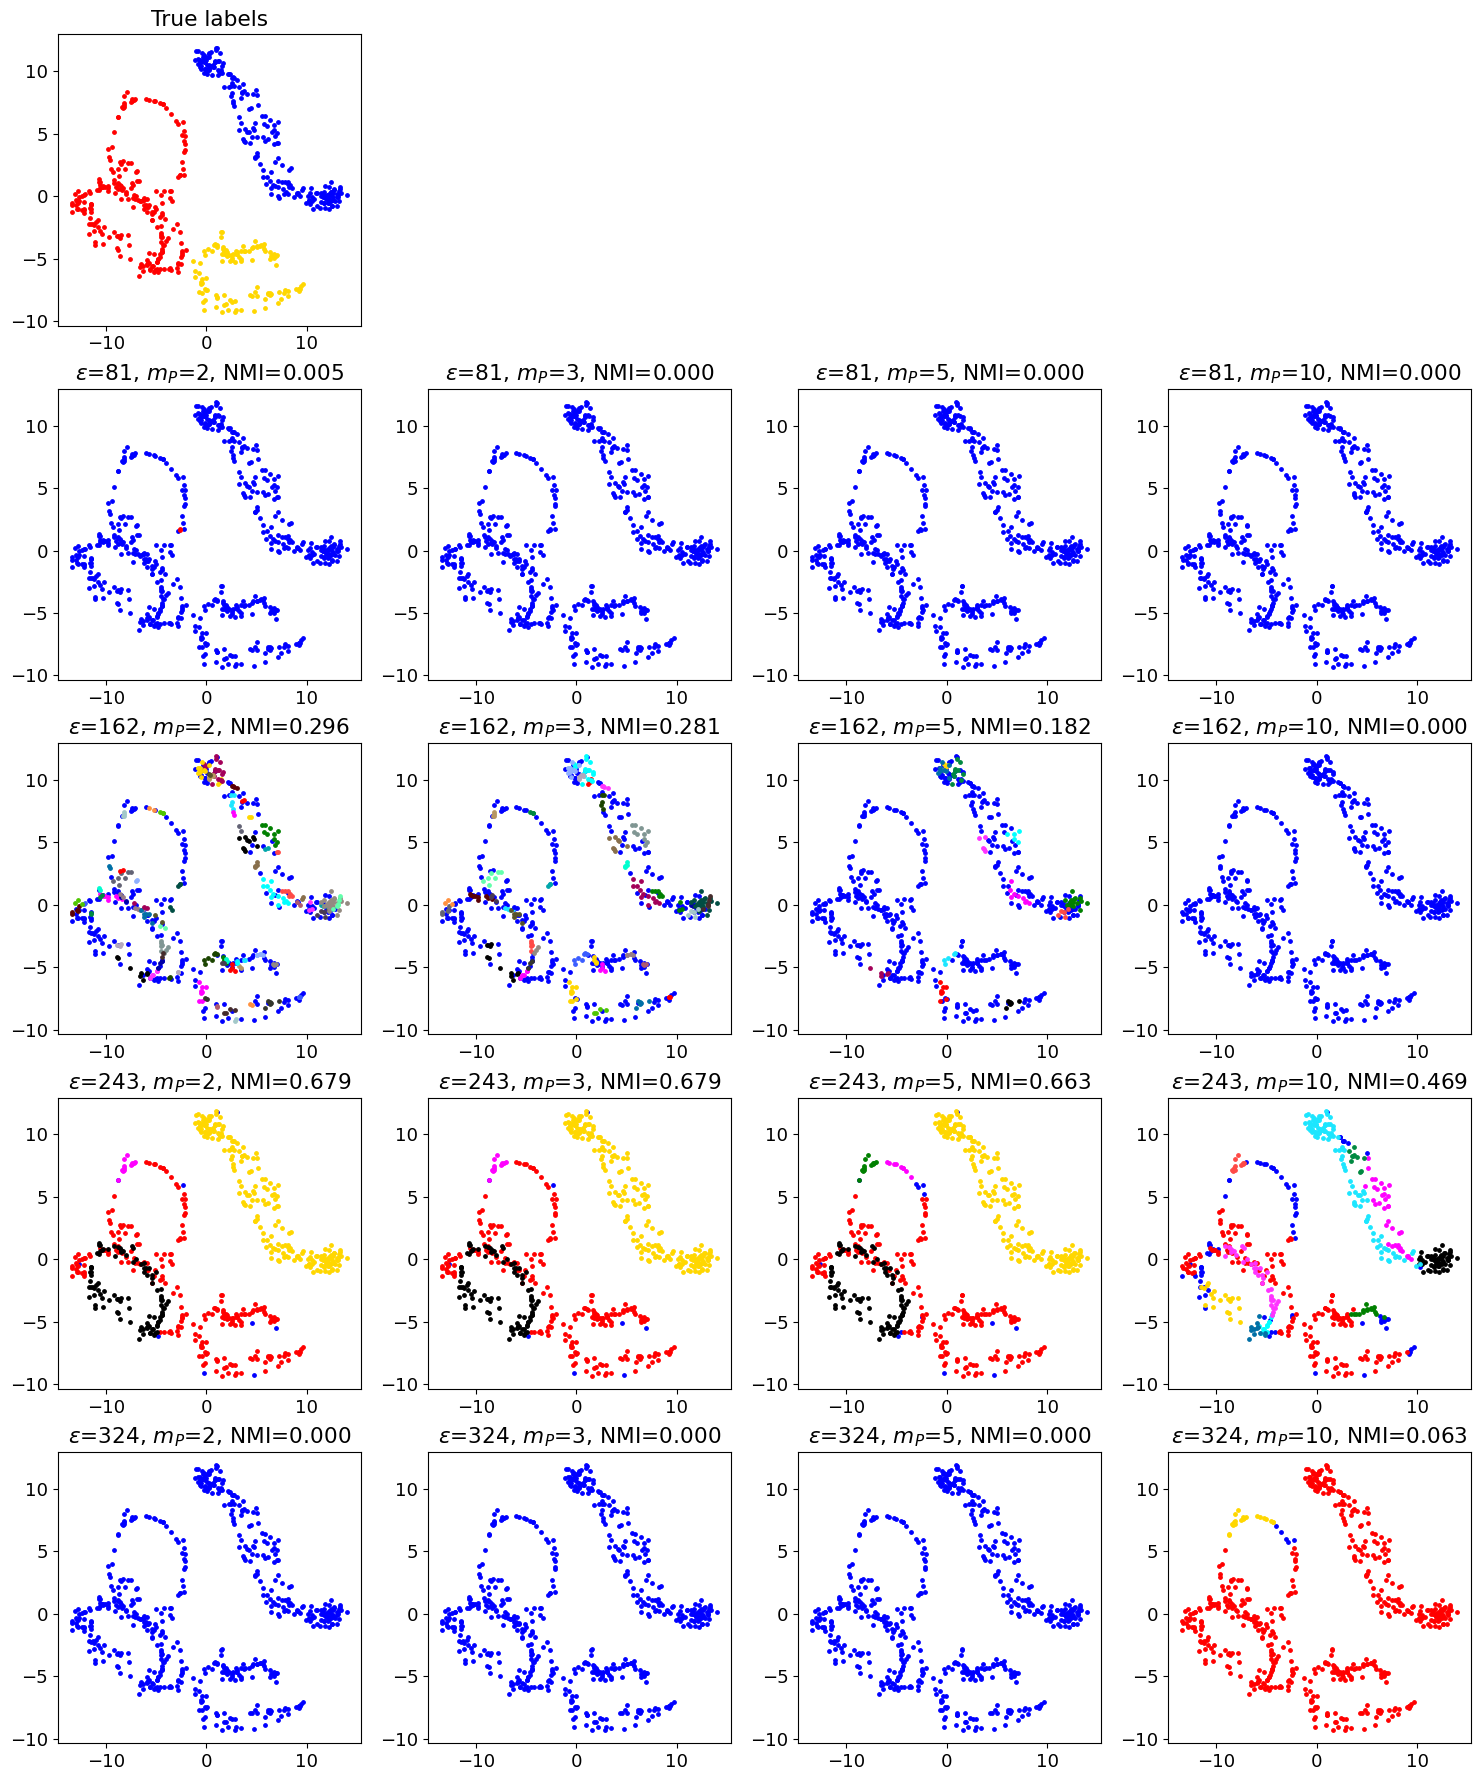

In [26]:
# DBSCAN has a few parameters, let's sweep over a few parameters and see what happens
np.random.seed(12345)

n_true_center = 3
best_visual = 2
#X, ytrue = make_blobs(10000, 2, n_true_center) # Generating random gaussian mixture
X3D = X_all[best_visual] # best visualization above
X = data
y_true = y

#eps_range = [0.01,0.1,0.5,1.0,10.]
if mean_min_dist<10:
    r=mean_min_dist
else:
    r = int(mean_min_dist)

# varying epsilon
eps_range = [r/2,r,1.5*r,2*r]

# varying minimum number of samples in epsilon range
min_sample_range = [2,3,5,10]
DIMY=len(eps_range)
DIMX=len(min_sample_range)

# plot
fig, ax = plt.subplots(DIMY+1,DIMX,figsize=(15,18))

# plotting true labels
i,j=0,0
nmi=1
plotting_ax(X3D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMX): fig.delaxes(ax[i,j])
    
# plotting with epsilon and min samples that vary
for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X)
        y_hat = model.labels_
        plotting_ax(X3D,y_hat,ax[i+1,j])
        nmi=NMI(y_true, y_hat)
        ax[i+1,j].set_title(r'$\epsilon$=%.0f, $m_P$=%i, NMI=%.3f'%(eps,min_samples,nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

## 1. NMI heatmap

We first plot the normalized mutual information (NMI) between true and predicted clusters varying the `dbscan` parameters, namely the minimum number of samples considered and the radius of the cluster size, $\epsilon$. In order to get the appropriate values for the parameters, we use for a certain radius the mean value for the i-th neighbour of our dataset points, corresponding to a min_sample of i.

In [27]:
# number of nearest neighbors
nn = 100

# fitting the algorithm on our data
nbrs = NearestNeighbors(n_neighbors=nn+1).fit(X3D) #, algorithm='ball_tree'

# retrieving distances matrix for every point from every i-th neighbor
d, ind = nbrs.kneighbors(X3D)
# transposing the distances matrix
# note: dd[0] has a trivial set of zeros
dd=d.T

# Define eps and minsample range based on our data
eps_range = np.mean(dd,axis=1)[1:]
min_sample_range = [i for i in range(1,nn+1)]

DIMY=len(eps_range)
DIMX=len(min_sample_range)

i,j=0,0
nmi=1

hmap=np.ones((DIMX,DIMY)) # define default heatmap
hmapred=np.zeros((DIMX,DIMY)) # define default heatmap

for i, eps in enumerate(eps_range):
    for j, min_samples in enumerate(min_sample_range):
        model = DBSCAN(eps=eps, min_samples=min_samples)
        model.fit(X3D)
        y_hat = model.labels_
        clustnumb=(len(set(y_hat))==3)
        nmi=metrics.normalized_mutual_info_score(y_hat, y_true)
        hmap[i,j]=nmi
        if clustnumb:
            hmapred[i,j]=nmi

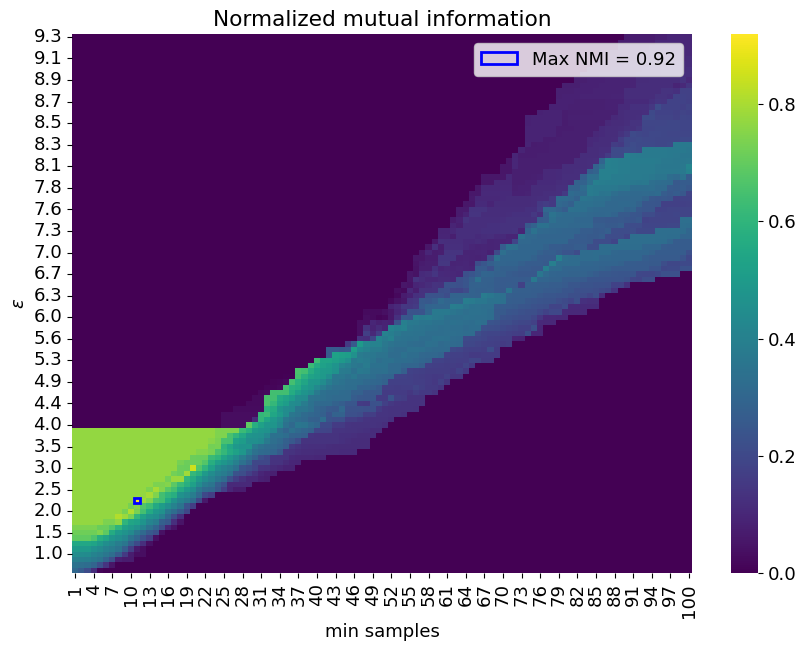

In [61]:
# display heatmap
htmap=pd.DataFrame(data=hmap[::-1],index=np.round(eps_range[::-1],1),columns=min_sample_range)
fig,ax=plt.subplots(figsize=(10,7))
sns.heatmap(htmap,cmap="viridis")
ax.set_title("Normalized mutual information")
maxvall=htmap.idxmax(axis=0)
plt.xlabel('min samples')
plt.ylabel('$\epsilon$')

maxval=htmap.max(axis=0).max()
i,c=np.where(htmap==maxval)

ax.add_patch(Rectangle((c,i),1,1, fill=False, edgecolor='blue', lw=2,label='Max NMI = {0}'.format(np.round(maxval,2))))
ax.legend(loc='best')

plt.show()

Above all the heatmap we see a trivial correlation between $\epsilon$ and min samples, but the high NMI region has a particular shape.

Using the parameters that renders the best NMI value we can get a pretty good classification with the DBSCAN clustering.

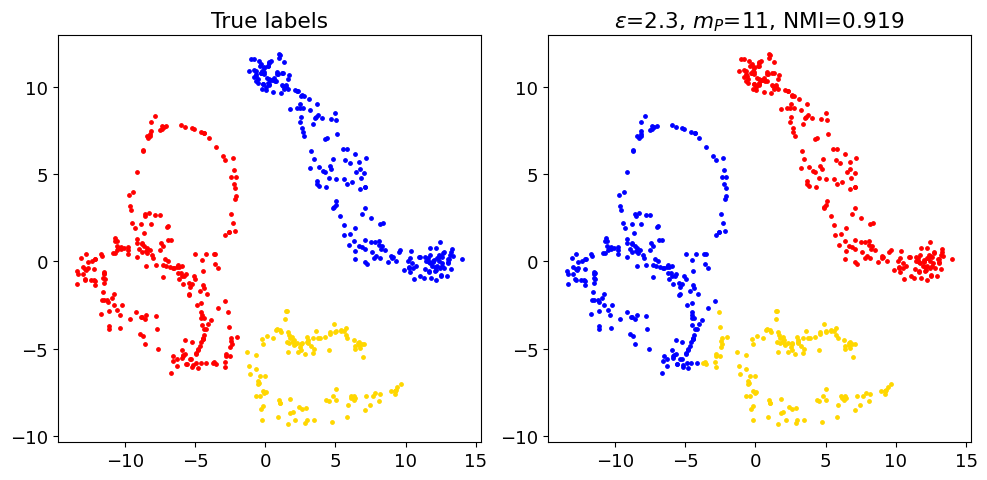

In [29]:
# plot
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

# plotting with epsilon and min samples that vary
model = DBSCAN(eps=float(eps_range[i]), min_samples=int(np.array(min_sample_range)[c]))
model.fit(X3D)
y_hat = model.labels_
plotting_ax(X3D,y,ax[0],)
plotting_ax(X3D,y_hat,ax[1])
nmi=NMI(y_true, y_hat)
ax[0].set_title('True labels')
ax[1].set_title(r'$\epsilon$=%.1f, $m_P$=%i, NMI=%.3f'%(float(eps_range[i]),int(np.array(min_sample_range)[c]),nmi))

plt.tight_layout(h_pad=0.5)
plt.show()

# 2. PCA to understand 12-dim data

We now perform a Principal Component Analysis to visualize the first components of the data.

In [30]:
# transpose data matrix
dataT = data.T
# find eigenvalues and eigenvectors of covariance matrix and sort them by principal component
U, spectrum, Vt = la.svd(dataT)
l = spectrum**2 / (data.shape[1] - 1)

Lambda = np.real_if_close(np.diag(l))

princ_comp = []

for i in range(Lambda.shape[0]):
    princ_comp.append(Lambda[i, i]/Lambda.trace())
    print(f'variability explained using up to PC {i+1}: {np.round(np.cumsum(princ_comp)[i] * 100, 1)} %')

variability explained using up to PC 1: 56.1 %
variability explained using up to PC 2: 86.4 %
variability explained using up to PC 3: 96.4 %
variability explained using up to PC 4: 96.9 %
variability explained using up to PC 5: 97.3 %
variability explained using up to PC 6: 97.8 %
variability explained using up to PC 7: 98.2 %
variability explained using up to PC 8: 98.6 %
variability explained using up to PC 9: 99.0 %
variability explained using up to PC 10: 99.3 %
variability explained using up to PC 11: 99.7 %
variability explained using up to PC 12: 100.0 %


The first 3 principal components explain the 96% of the data variability, we then redefine the data on the basis yelded by these components.

In [31]:
# rotate the data and divide in the 3 classes according to their label
rotated_data = np.dot(U, dataT)

rotated_data_0 = rotated_data.T[y_true == 0]
rotated_data_1 = rotated_data.T[y_true.T == 1]
rotated_data_2 = rotated_data.T[y_true.T == 2]

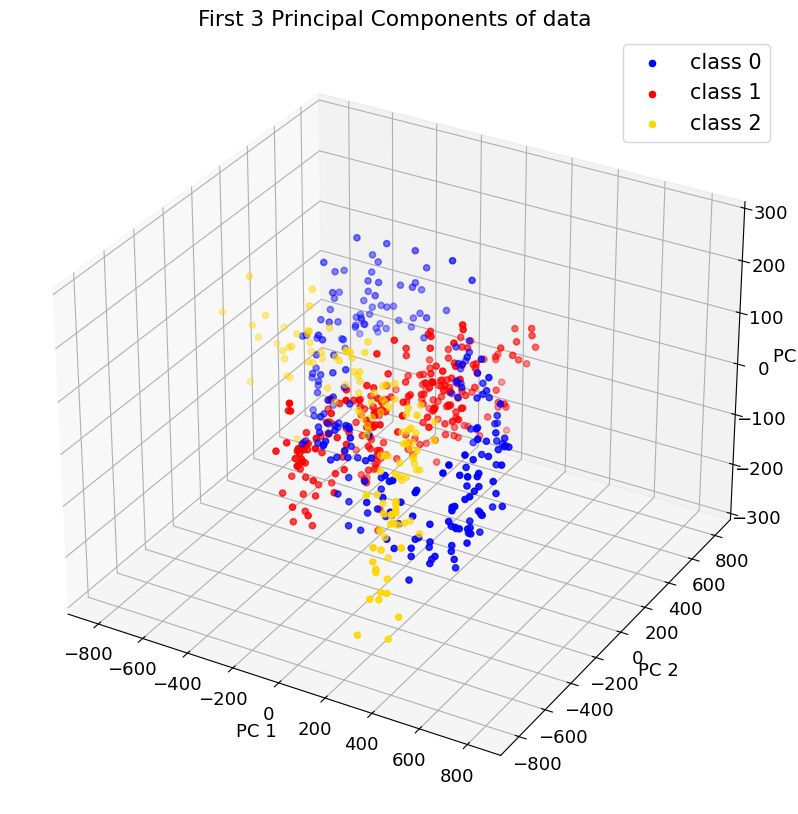

In [32]:
# remove the comment from the following line to perform a rotating 3D plot
# and better visualize dataset after PCA
# %matplotlib widget

# plot the first three principal component rotated data
scale_factor = 0.005

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
ax.scatter3D(rotated_data_0[:,0], rotated_data_0[:,1], rotated_data_0[:,2], label='class 0', c='blue')
ax.scatter3D(rotated_data_1[:,0], rotated_data_1[:,1], rotated_data_1[:,2], label='class 1', c='red')
ax.scatter3D(rotated_data_2[:,0], rotated_data_2[:,1], rotated_data_2[:,2], label='class 2', c='gold')
ax.set_xlim(-900,900)
ax.set_ylim(-900,900)
ax.set_zlim(-300,300)
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_zlabel('PC 3')
ax.legend(fontsize=15)
plt.title('First 3 Principal Components of data')
plt.show()

From the 3D rotating plot we can see some structures (thanks to the true labels), so we plot the 3 projection to understand better the dataset structure.

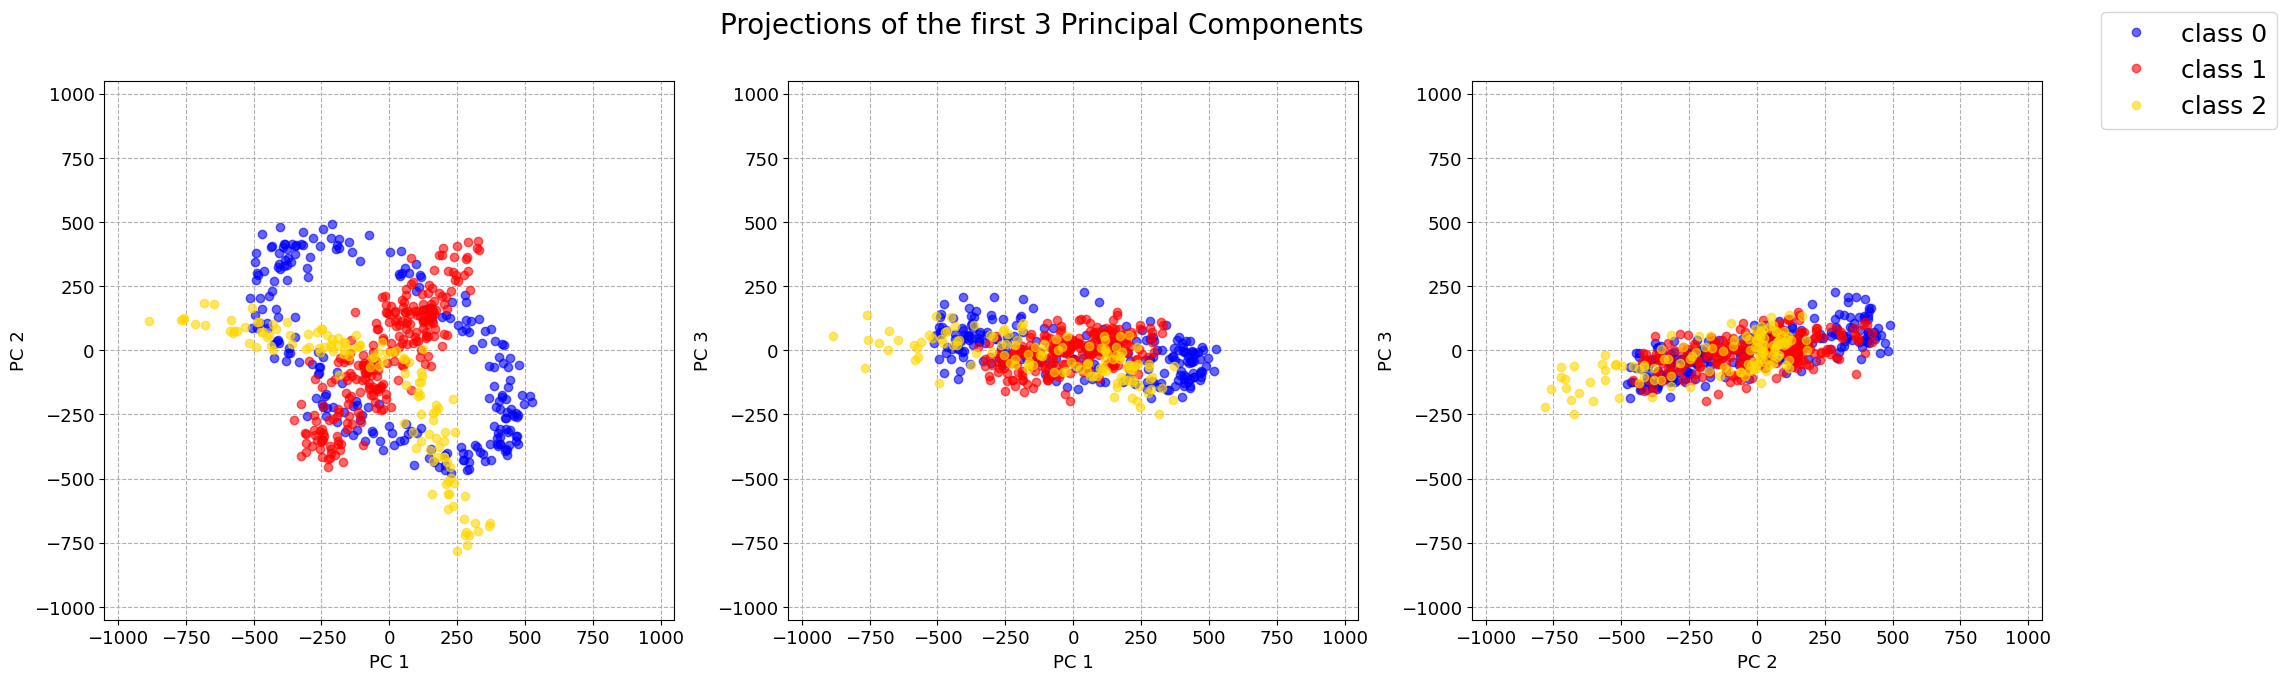

In [46]:
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (25, 7))

maxlim = 1050

ax[0].plot(rotated_data_0[:, 0], rotated_data_0[:, 1], 'o', alpha = .6, label = 'class 0', c='blue')
ax[0].plot(rotated_data_1[:, 0], rotated_data_1[:, 1], 'o', alpha = .6, label = 'class 1', c='red')
ax[0].plot(rotated_data_2[:, 0], rotated_data_2[:, 1], 'o', alpha = .6, label = 'class 2', c='gold')
ax[0].set_xlim(-maxlim, maxlim)
ax[0].set_ylim(-maxlim, maxlim)
ax[0].set_xlabel('PC 1', fontsize=13)
ax[0].set_ylabel('PC 2', fontsize=13)
ax[0].grid(True, linestyle='--')

ax[1].plot(rotated_data_0[:, 0], rotated_data_0[:, 2], 'o', alpha = .6, c = 'blue')
ax[1].plot(rotated_data_1[:, 0], rotated_data_1[:, 2], 'o', alpha = .6, c = 'red')
ax[1].plot(rotated_data_2[:, 0], rotated_data_2[:, 2], 'o', alpha = .6, c = 'gold')
ax[1].set_xlim(-maxlim, maxlim)
ax[1].set_ylim(-maxlim, maxlim)
ax[1].set_xlabel('PC 1', fontsize=13)
ax[1].set_ylabel('PC 3', fontsize=13)
ax[1].grid(True, linestyle='--')

ax[2].plot(rotated_data_0[:, 1], rotated_data_0[:, 2], 'o', alpha = .6, c = 'blue')
ax[2].plot(rotated_data_1[:, 1], rotated_data_1[:, 2], 'o', alpha = .6, c = 'red')
ax[2].plot(rotated_data_2[:, 1], rotated_data_2[:, 2], 'o', alpha = .6, c = 'gold')
ax[2].set_xlim(-maxlim, maxlim)
ax[2].set_ylim(-maxlim, maxlim)
ax[2].set_xlabel('PC 2', fontsize=13)
ax[2].set_ylabel('PC 3', fontsize=13)
ax[2].grid(True, linestyle='--')

fig.legend(fontsize=18)
fig.suptitle('Projections of the first 3 Principal Components', fontsize=20)
plt.show()

It can be seen from the first plot above that the dimensional reducted dataset up to the first 2 Principal Components still maintains its structure and 3 clusters are very recognizable from their shape.

# 3. Compare different clustering methods

Now we compare two different clustering methods, k-means and hierarchical clustering, and compare their performance with DBSCAN.

## 3.1 k-means clustering

We perform clustering with k-means algorithm searching for 3 clusters. We also compare the two methods to compute distance. We evaluate the performance of the clustering with NMI.

In [34]:
# defining param for k means 
clust = 3
maxiter = 500
# different initializations
ninit =  np.arange(1,100,20)  
# algorithm to compute distance  
alg = ['lloyd', 'elkan']     

DIMY=len(ninit)
DIMX=len(alg)

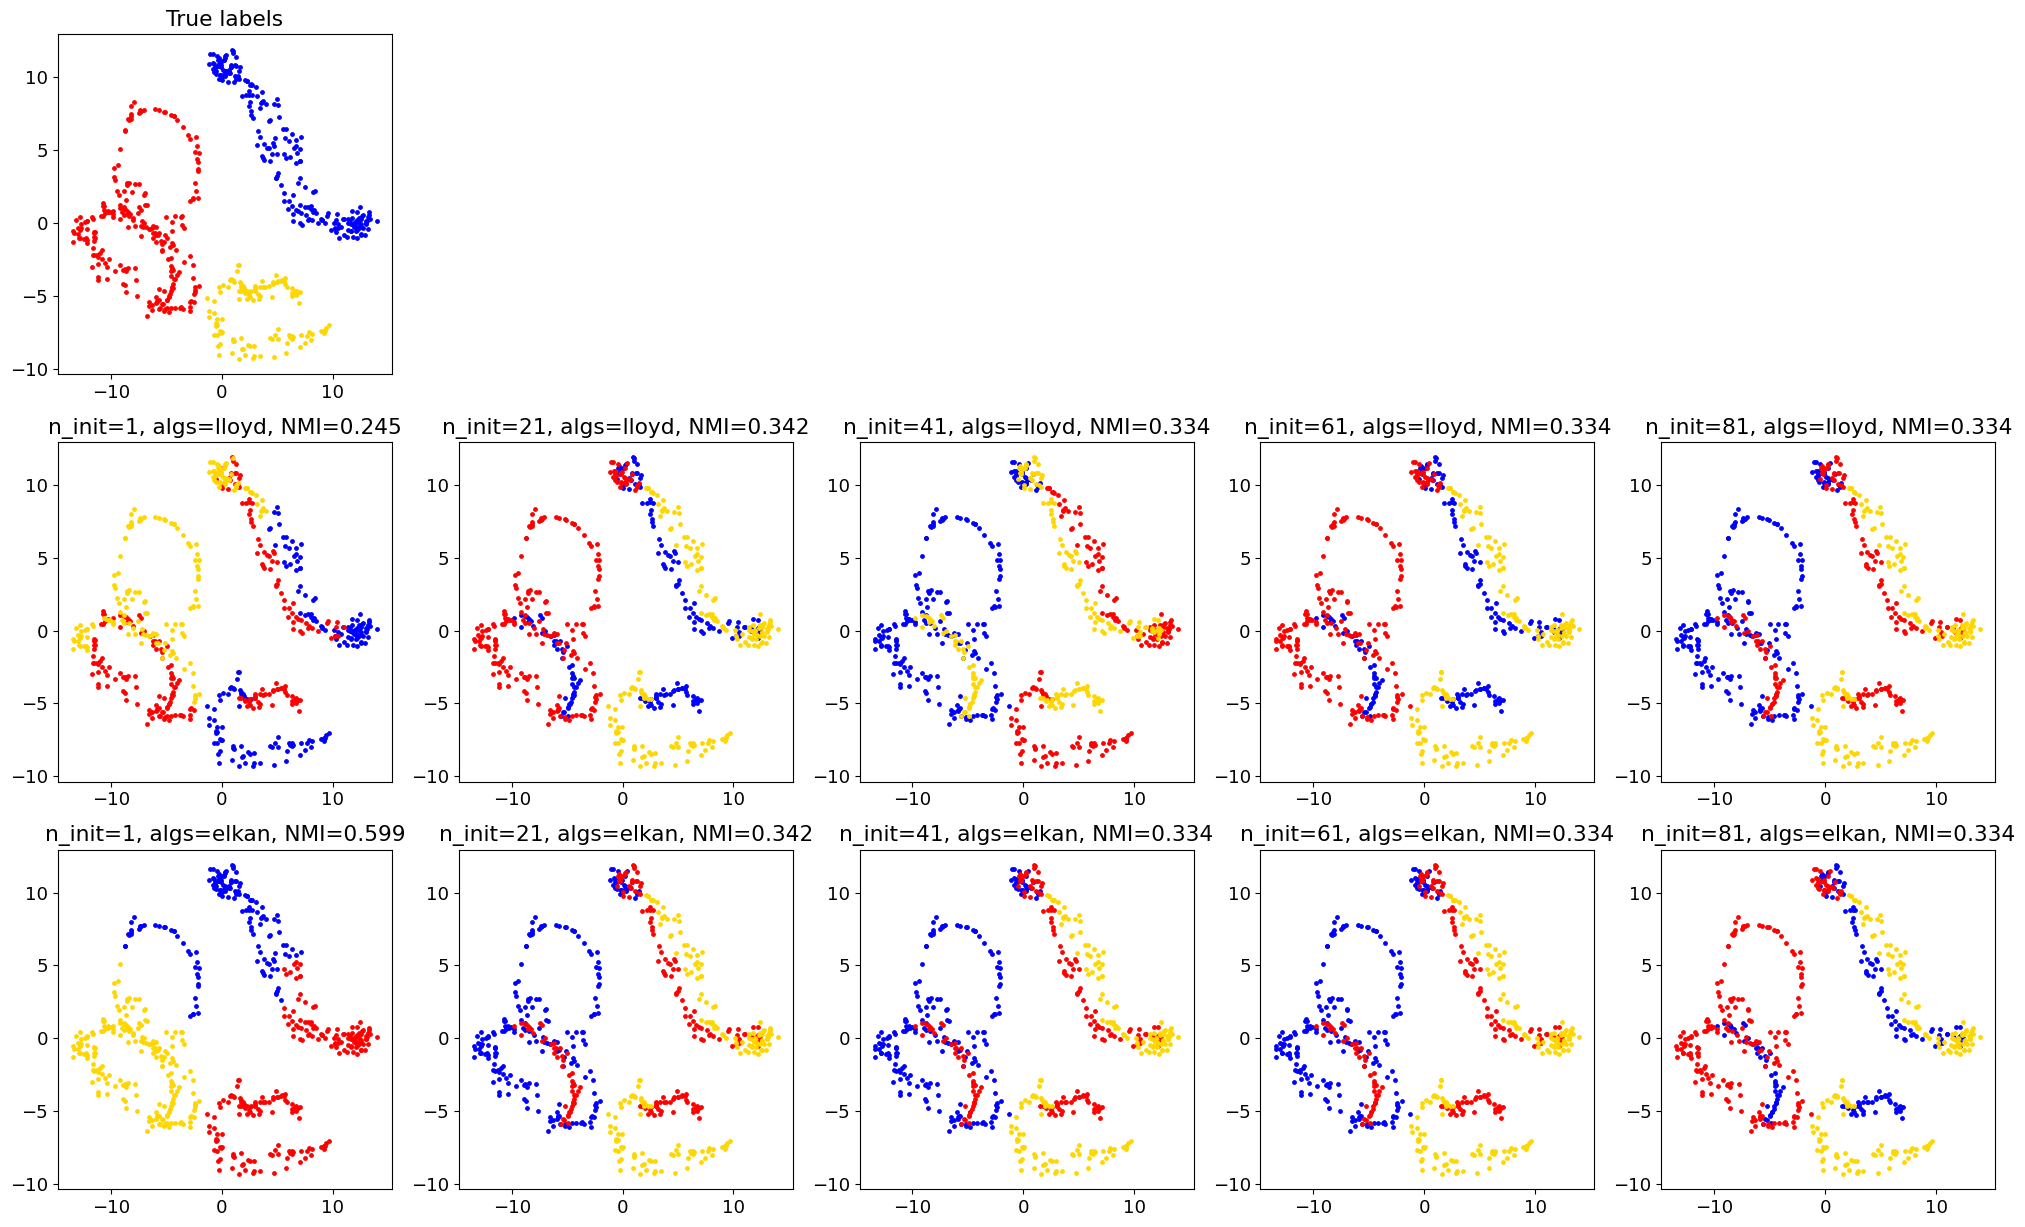

In [35]:
# plot
fig, ax = plt.subplots(DIMX+1,DIMY,figsize=(25,15))

i,j = 0,0
nmi=1
plotting_ax(X3D,y,ax[i,j])
ax[i,j].set_title('True labels')
for j in range(1,DIMY): fig.delaxes(ax[i,j])
    
for i, a in enumerate(alg): # loops through kmeans param
    for j, n in enumerate(ninit):
        model = KMeans(n_clusters=clust, max_iter=maxiter, algorithm=a, n_init=n  )   # init the DBSCAN alg with the given parameter
        model.fit(X3D)    # predict labels 
        y_hat = model.labels_   # y_hat = predicted label 
        plotting_ax(X3D,y_hat,ax[i+1,j])
        nmi=NMI(y_true, y_hat)  # compute NMI
        ax[i+1,j].set_title(f'n_init={n}, algs={a}, NMI={nmi:.3}')

In the plots above, we have decided to perform KMeans clustering on the reduced 3-dimensional dataset (from t-SNE) with different distance algorithms. As we can observe, the k-means clustering algorithm isn't able to detect any specific patterns or clusters within the data. The strong constraint to clusterize the data into spheres doesn't allow for the detection of more complex geometries. It is clear that it performs badly compared to DBSCAN.

## 3.2 Hierarchical clustering

We now perform hierarchical clustering (agglomerative): this algorithm begins with the assignement of each point as a cluster, then it aggregates hierarchically clusters stopping when one cluster (the whole dataset) remains. We use different methods to compute at each iteration distance between clusters and consequently aggregate them:
* `single`: the distance between two clusters is computed as the minimum distance between two points belonging respectively to the first and the second cluster
* `ward`: uses the Ward variance minimization algorithm
* `average`: the distance between two clusters is computed as the average distance between two points belonging respectively to the first and the second cluster
* `weighted`: the distance between two clusters is computed as the mean between the distance of the first cluster and a third cluster and the distance between the second cluster and a third cluster
* `centroid`: the distance of a cluster is computed as the distance of their centroids
* `median`: similar to `centroid` with a small difference in computing the centroid of the new cluster

We applicate the clustering algorithm on the reduced data from t-SNE (3 dimensions) and we plot dendrograms to visualize the different levels of similarity between data points.

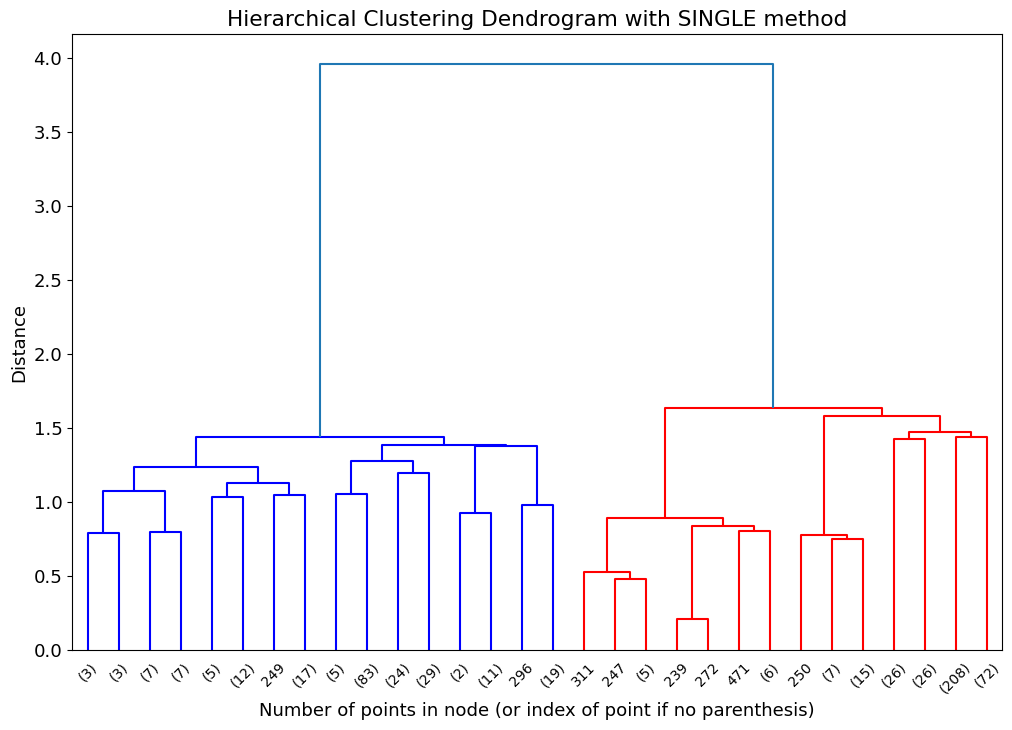

In [66]:
# level at which perform truncating in visualization
# no more than level_thr levels are displayed
level_thr = 4

# perform hierarchical clustering 
hierarchical_model = linkage(X3D, method='single')

# display dendrogram
plt.figure(figsize=(12,8))
set_link_color_palette(cpalette)
dendrogram(hierarchical_model, truncate_mode='level', p=level_thr)
plt.title('Hierarchical Clustering Dendrogram with SINGLE method')
plt.xlabel('Number of points in node (or index of point if no parenthesis)')
plt.ylabel('Distance')
plt.show()

This performance is reasonable according to the 2D plot of the reduced data in which we see two really close clusters and the clustering method (single linkage) that leads in finding only 2 clusters. In the red one, indeed, we see the branch on the left that indicates more distant points, and these should be the third cluster, as will be confirmed in the plot below. However, we can identify a distance cutoff (above 1.5) to distinguish 3 clusters.

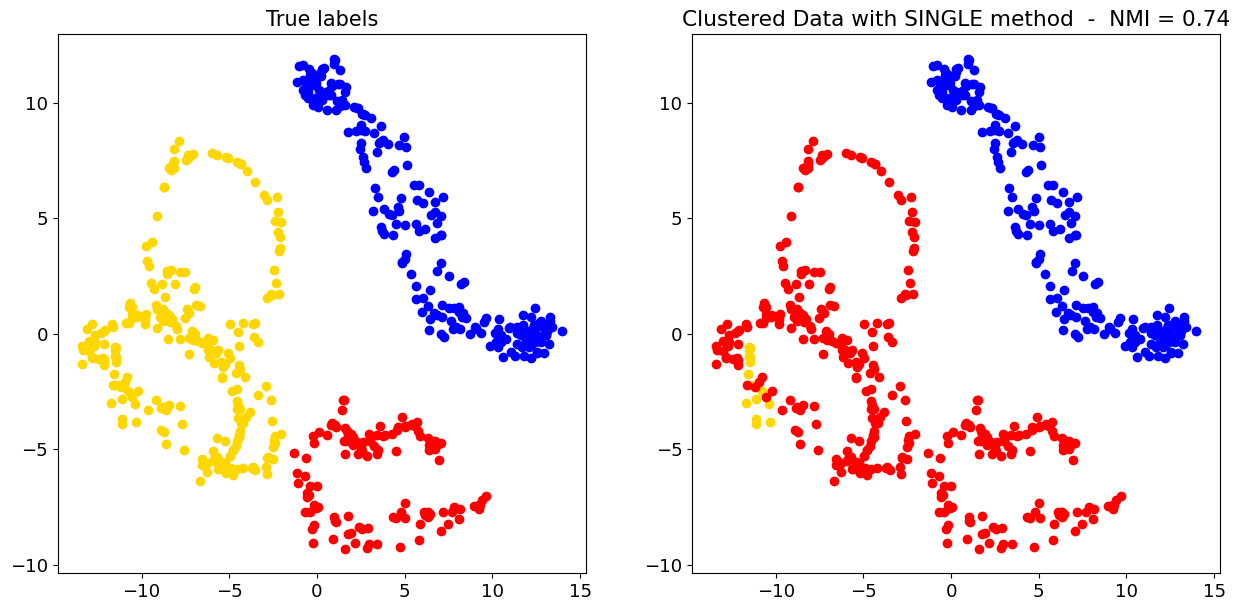

In [71]:
# check if it does performs better than DBSCAN

# getting predicted label from each point
hcluster_labels = fcluster(hierarchical_model, n_true_center, criterion='maxclust')

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))
colors_h = ['blue', 'gold', 'red']

for cluster in range(1, n_true_center + 1):
    ax[0].scatter(X3D[y_true == cluster-1, 0], X3D[y_true == cluster-1, 1], color = colors_h[cluster-1])
ax[0].set_title('True labels', fontsize=15)

for cluster in range(1, n_true_center + 1):
    ax[1].scatter(X3D[hcluster_labels == cluster, 0], X3D[hcluster_labels == cluster, 1], color = colors_h[cluster-1])
ax[1].set_title(f'Clustered Data with SINGLE method  -  NMI = {NMI(y_true,hcluster_labels):.2f}')

plt.show()

We can observe that this algorithm almost cannot distinguish the two closest clusters and fro this point of view it performs quite bad with respect to DBSCAN. However, overall, we obtain a quite good NMI, higher with respect to DBSCAN (without optimal parameters). To better compare the two algorithms the performance of DBSCAN should be refined around the hyperparameters value in the third row of the plot before Section 1.

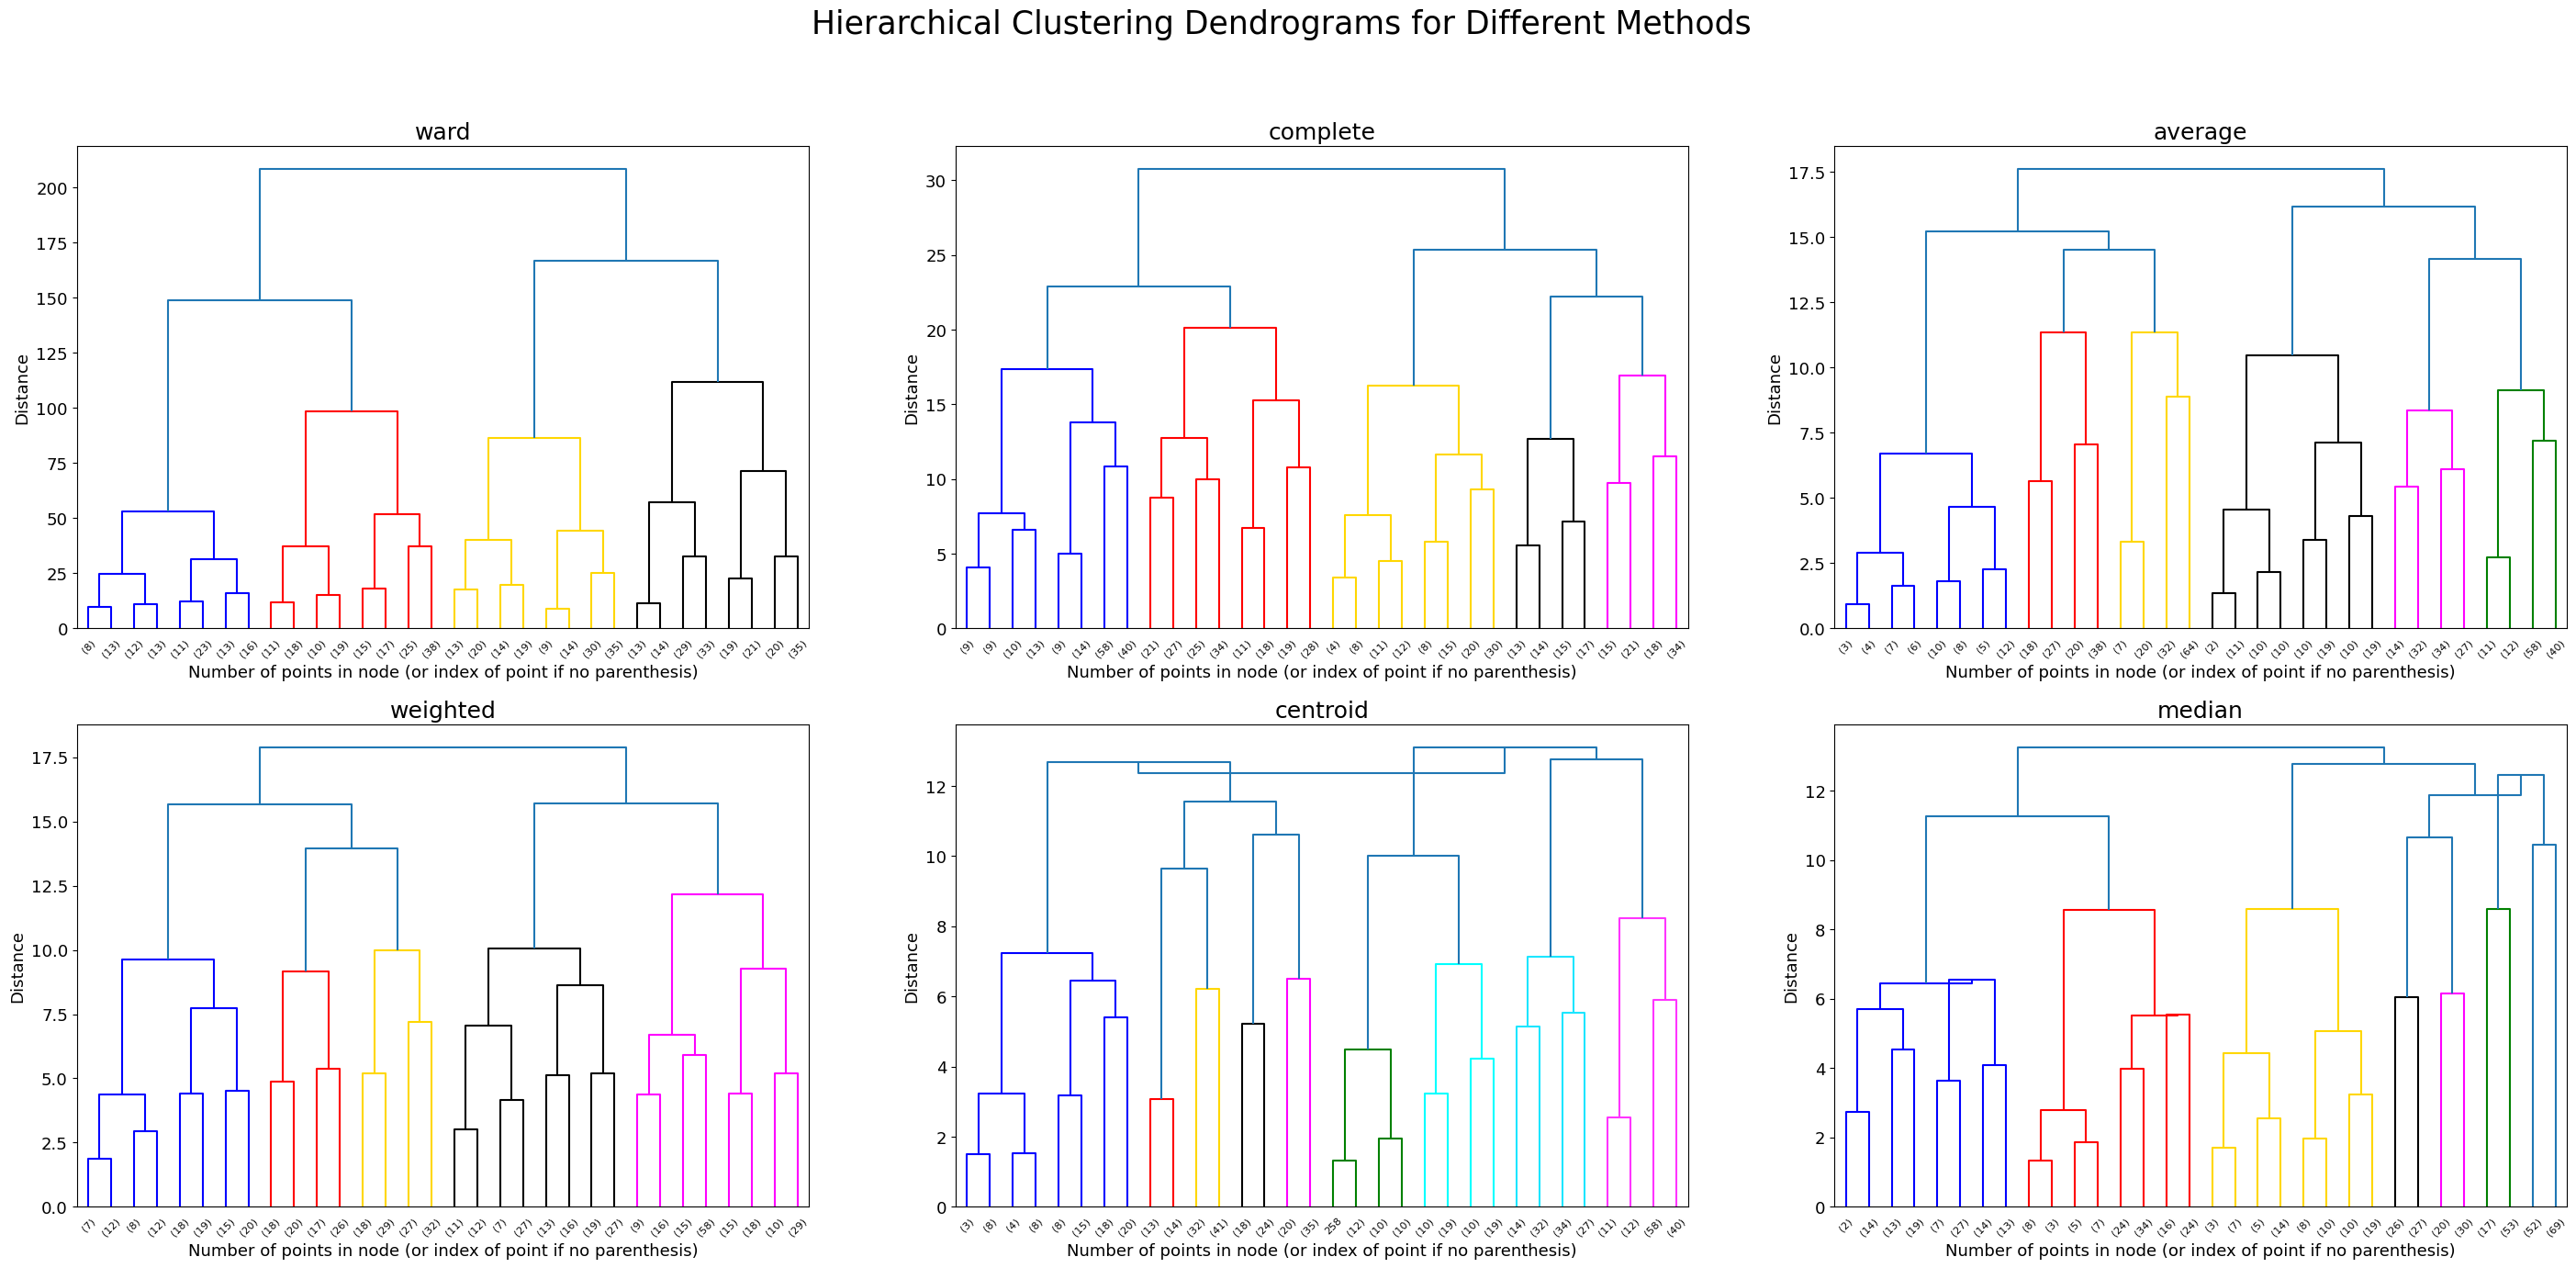

In [68]:
# now we try different methods for hierarchical clustering
h_methods = ['ward', 'complete', 'average', 'weighted', 'centroid', 'median']

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(35,15))
fig.suptitle('Hierarchical Clustering Dendrograms for Different Methods', fontsize=25)

h_linkage_matrixes = []

# perform hierarchical clustering for every method
for i,m in enumerate(h_methods):
    row = i // 3
    col = i % 3
    # clustering
    hm = linkage(X3D, method=m)
    h_linkage_matrixes.append(hm)
    # display dendrogram
    set_link_color_palette(cpalette)
    dendrogram(hm, truncate_mode='level', p=level_thr, ax=ax[row][col])
    ax[row][col].set_title(m, fontsize=18)
    ax[row][col].set_xlabel('Number of points in node (or index of point if no parenthesis)', fontsize=13)
    ax[row][col].set_ylabel('Distance', fontsize=13)
plt.show()

From the plot above we can see that every method find at least 4 clusters, but in the first three (first row) it is possible to choose a cutoff in distance to distinguish 3 clusters. It appears that each method identify a particular shape in the dataset, as we will see from the plot below.

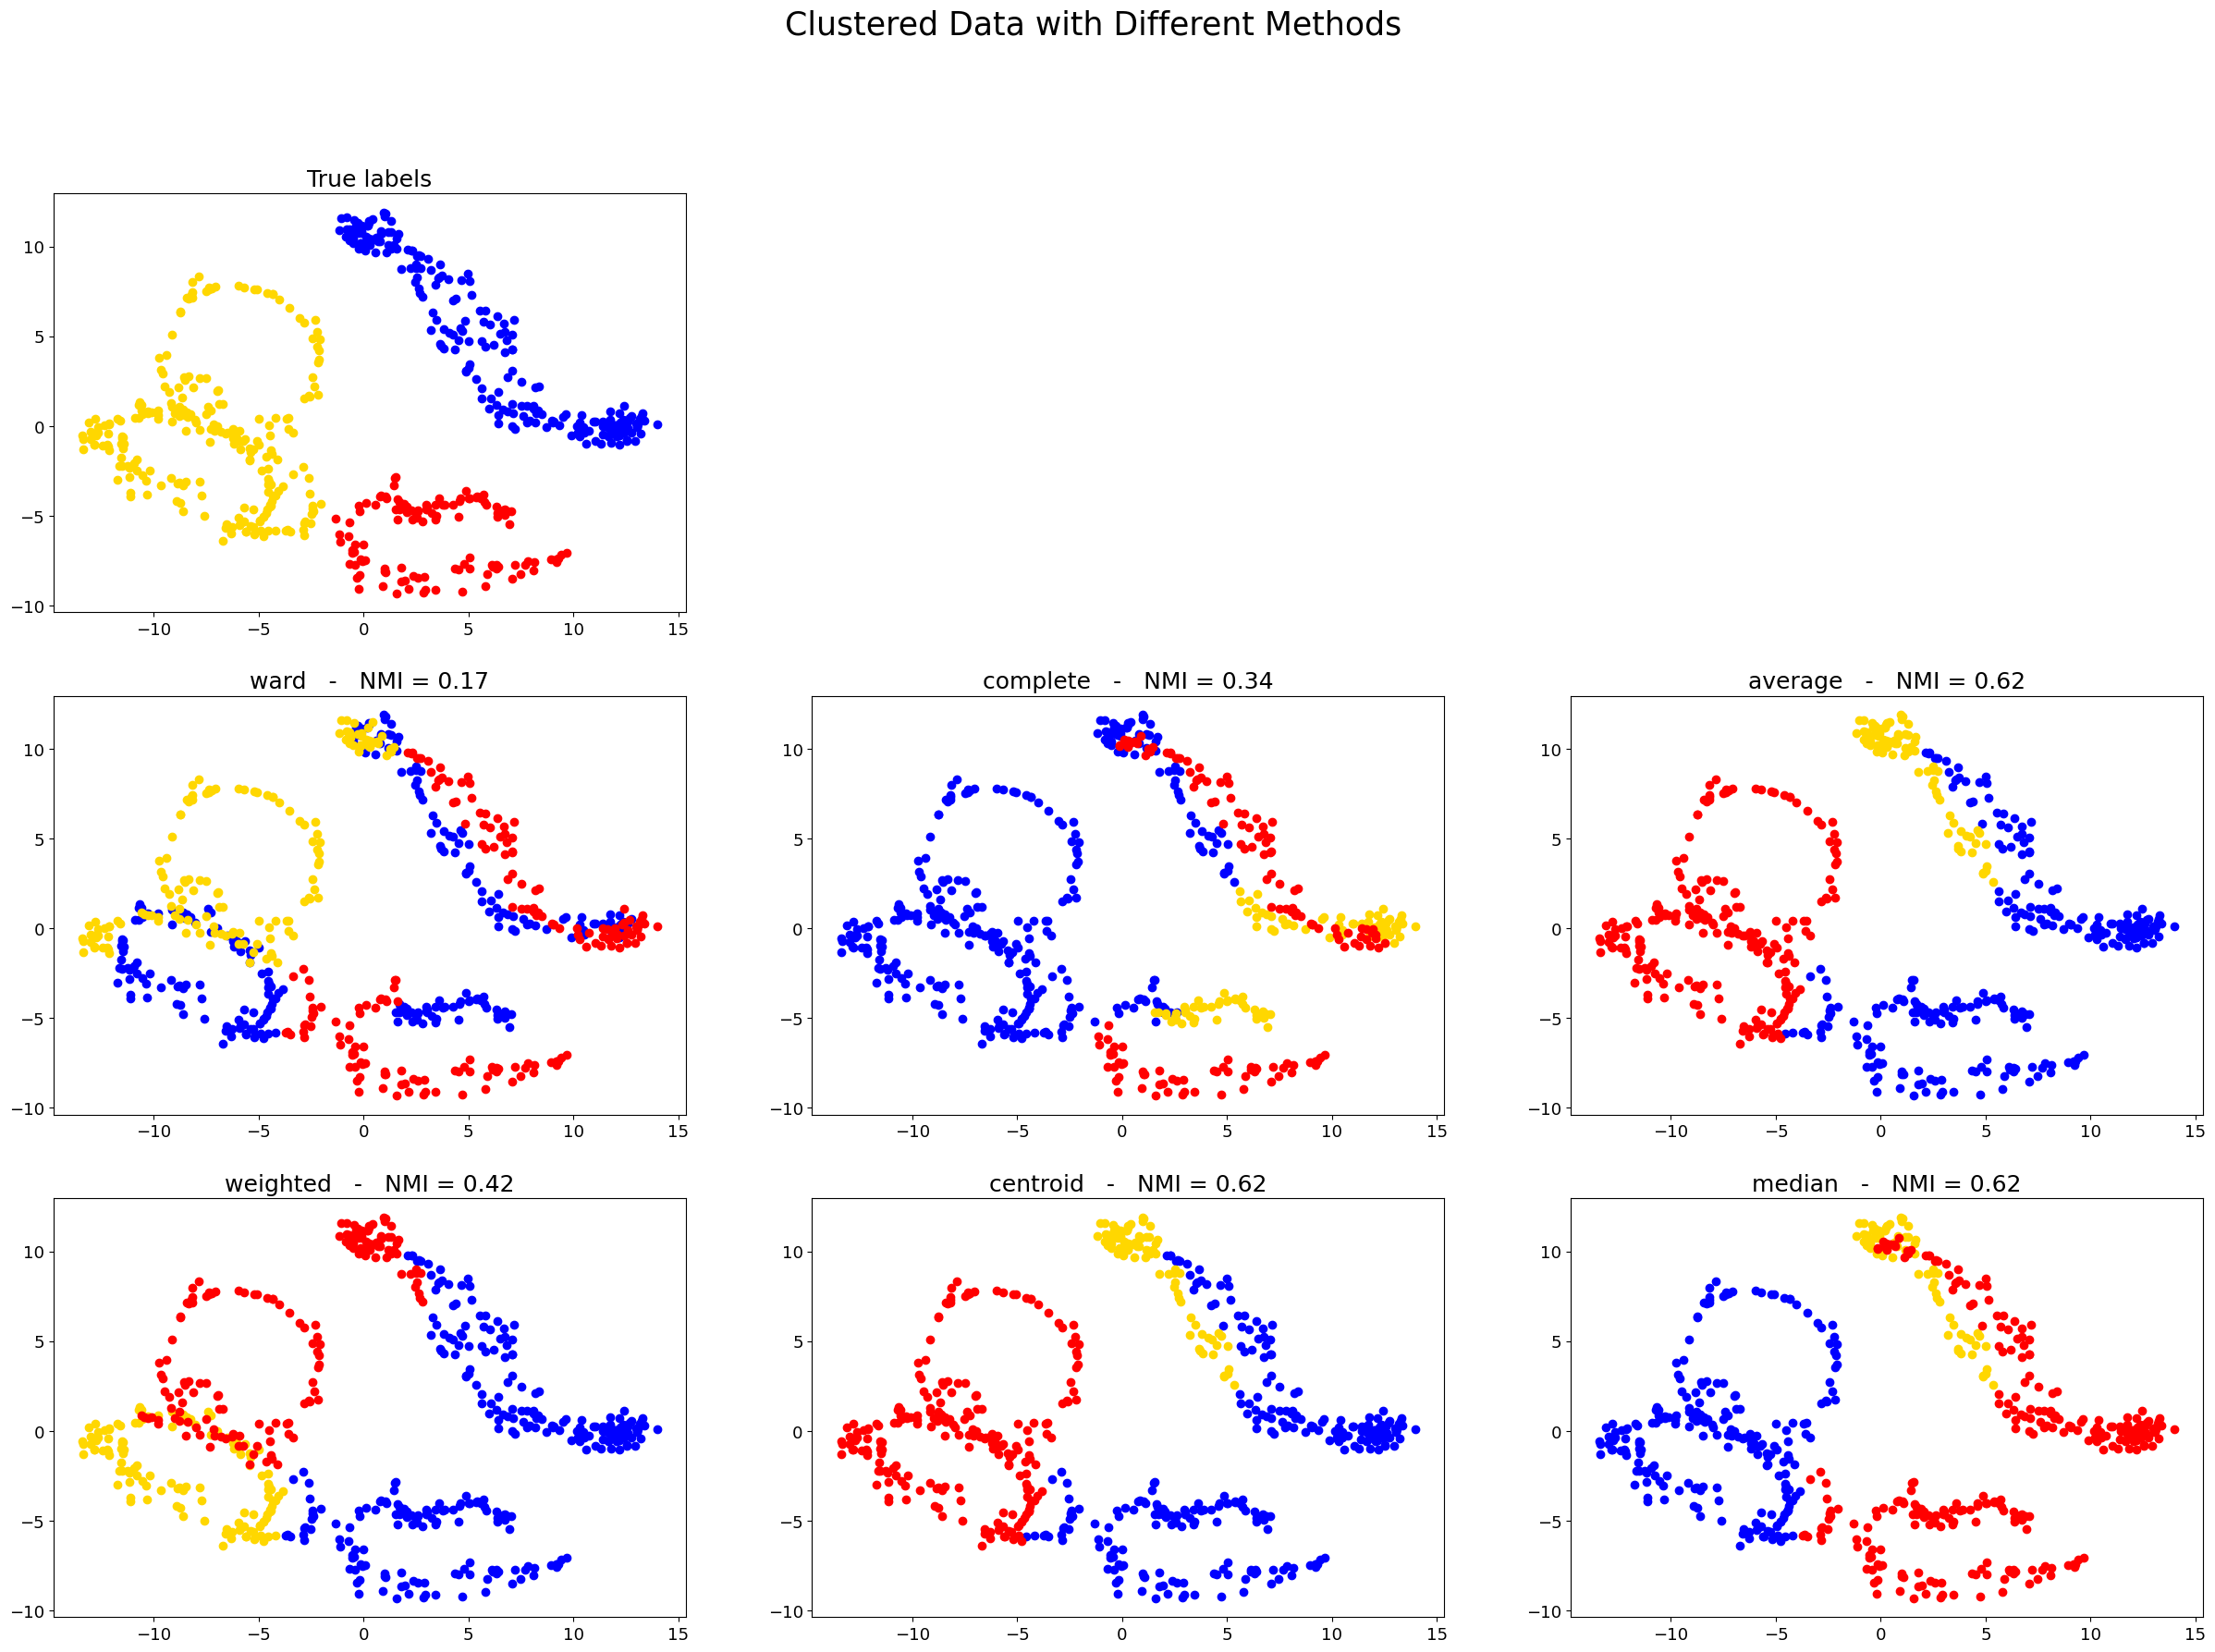

In [72]:
# other methods

fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(30,20))
fig.suptitle('Clustered Data with Different Methods', fontsize=25)

for cluster in range(1, n_true_center + 1):
    ax[0, 0].scatter(X3D[y_true == cluster-1, 0], X3D[y_true == cluster-1, 1], color = colors_h[cluster-1])
ax[0, 0].set_title('True labels', fontsize=18)

# getting predicted label from each point for each method
for i, hm in enumerate(h_linkage_matrixes):
    row = i // 3
    col = i % 3
    hl = fcluster(hm, n_true_center, criterion='maxclust')
    for cluster in range(1, n_true_center + 1):
        ax[row+1][col].scatter(X3D[hl == cluster, 0], X3D[hl == cluster, 1], color = colors_h[cluster-1])
        t = h_methods[i] + '   -   ' + f'NMI = {NMI(y_true, hl):.2f}'
        ax[row+1][col].set_title(t, fontsize=18)

fig.delaxes(ax[0][2])
fig.delaxes(ax[0][1])
plt.show()

From the plot above we can notice that the other methods performs badly with respect to single linkage.

# 4. Others visualization methods

In this final section, we explore how various manifold learning approaches can transform data. Thanks to manifold learning algorithms, we can visualize the dataset by reducing its dimensionality. This projection simplifies data visualization and simultaneously try to preserve the nonlinear relationships among variables. Below, we employ different manifold learning methods. Through the interactive graph, is it possible to modify the number of neighbors utilized by the various models and observe the resultant transformations.

For more information about the algorithms see [here](https://scikit-learn.org/stable/modules/manifold.html#manifold).

In [40]:
def plot_manifold_learning(n_neighbors=15):
    fig = plt.figure(figsize=(25, 8))
    plt.suptitle("Manifold Learning with %i neighbors" % n_neighbors, fontsize=14)

    # manifold learning models 
    methods = ["standard", "ltsa",  "modified", 'hessian', "isomap", "mds", "spectral_embedding", "tsne"]
    labels = ["LLE", "LTSA", "Modified LLE", 'hessian LLE', "Isomap", "MDS", "Spectral Embedding", "t-SNE"]
    
    for i, method in enumerate(methods):
        t0 = time()
        
        # manifold learning models 
        if method in ["standard", "ltsa", "modified", 'hessian']:
            trans_data = manifold.LocallyLinearEmbedding(
                n_neighbors=n_neighbors, n_components=2, method=method, 
                eigen_solver='dense', random_state=42).fit_transform(data).T
        elif method == "isomap":
            trans_data = manifold.Isomap(n_neighbors=n_neighbors, n_components=2).fit_transform(data).T
        elif method == "mds":
            mds = manifold.MDS(3, max_iter=100, n_init=1, random_state=42)
            trans_data = mds.fit_transform(data).T
        elif method == "spectral_embedding":
            se = manifold.SpectralEmbedding(n_components=2, n_neighbors=n_neighbors, random_state=42)
            trans_data = se.fit_transform(data).T
        elif method == "tsne":
            tsne = manifold.TSNE(n_components=2, random_state=42)
            trans_data = tsne.fit_transform(data).T
        
        t1 = time()
        
        # Plotting
        ax = fig.add_subplot(2, 4, i+1)  
        for lbl, color in zip(np.unique(y_true), ['b', 'r', 'gold']):
            idx = y_true == lbl
            ax.scatter(trans_data[0, idx], trans_data[1, idx], c=color, s=6, label=str(lbl))
        plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        plt.axis("tight")

In [41]:
# Widget 
interact(plot_manifold_learning, 
         n_neighbors = BoundedIntText(value=12, min=6, max=30, step=1, description='neighbors:', disabled=False))
plt.show()

interactive(children=(BoundedIntText(value=12, description='neighbors:', max=30, min=6), Output()), _dom_class…

In [42]:
# clustering with best visualization method
spectral = trans_data = manifold.SpectralEmbedding(n_components=2, n_neighbors=9)
trans_data = spectral.fit_transform(data)

In [43]:
clust = 3
clustering_model = AgglomerativeClustering(n_clusters = clust , linkage='complete')
clustering_model.fit(trans_data)
y_pred = clustering_model.labels_
nmi = np.round(NMI(y_true,y_pred),3)

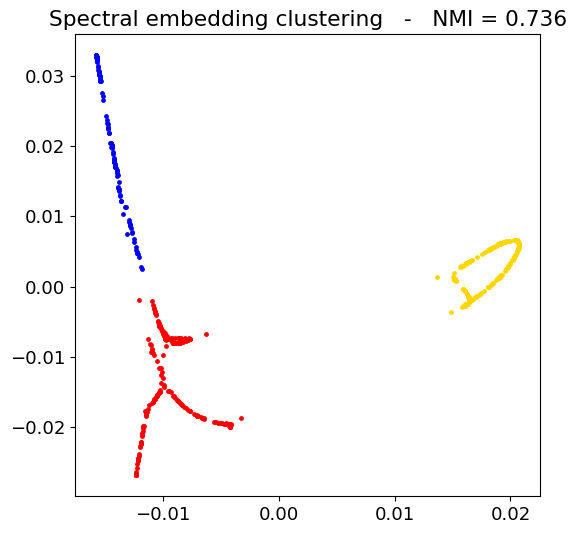

In [53]:
fig,ax = plt.subplots(1,1, figsize=(6,6))
for lbl, color in zip(np.unique(y_true), ['b', 'r', 'gold']):
    ax.scatter(trans_data[y_pred==lbl][:,0],trans_data[y_pred==lbl][:,1], c=color, s = 6 )
# ax.xaxis.set_major_formatter(NullFormatter())
# ax.yaxis.set_major_formatter(NullFormatter())
ax.set_title(f'Spectral embedding clustering   -   NMI = {nmi}')
plt.show()